In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from seismic_purifier.config import BATCH_SIZE
from seismic_purifier.representation_learning_models import (
    RepresentationLearningSingleAutoencoder,
    RepresentationLearningDenoisingSingleAutoencoder,
    RepresentationLearningMultipleAutoencoder
)
from seismic_purifier.classifier_models import (
    ClassifierAutocovariance, 
    ClassifierAugmentedAutoencoder, 
    ClassifierMultipleAutoencoder
)
import matplotlib.pyplot as plt

2025-06-24 12:30:50.581240: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 12:30:50.636875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 12:30:50.636909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 12:30:50.636944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 12:30:50.644769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 12:30:50.645344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [3]:
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Limit memory growth to avoid consuming all GPU memory
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

In [9]:
# ============================
# 1. Configuration
# ============================

# Paths to your data
TEST_DATA_PATH = '/home/ege/rawcovar_data/processed_data/KO.GAZK.20200908_235818.npy' 
TEST_LABEL_PATH = "/home/ege/rawcovar_data/processed_data/KO.GAZK.y_condensed.npy"
# Paths to your model
MODEL_PATH = '/home/ege/rawcovar/experiments/MARMARA_CROSS_EXP_1_2020-09/model5/KO.MRMT_20200909_representation_cross_covariances_5epochs.h5'

In [10]:
# ============================
# 2. Data loading
# ============================
X_test = np.load(TEST_DATA_PATH)
print(f"Test data shape: {X_test.shape}")

Y_test = np.load(TEST_LABEL_PATH)  # Expected shape: (num_samples)
print(f"Test label shape: {Y_test.shape}")

Test data shape: (692, 3000, 3)
Test label shape: (692,)


In [8]:
Y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

In [7]:
Y_test.sum()

13

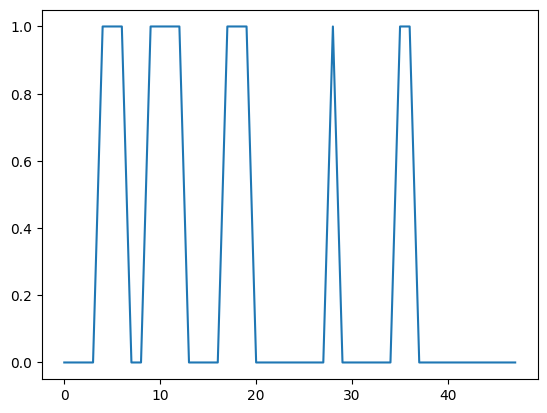

In [8]:
plt.plot(Y_test)

In [9]:
Y_test.shape

(48,)

In [10]:
# ============================
# 3. Representation Learning Model Instantiation
# ============================

# Choose the model you want to train
# For example, using RepresentationLearningSingleAutoencoder
#model = RepresentationLearningSingleAutoencoder(
# name="rep_learning_autoencoder"
#)

# Alternatively, you can choose other models:
# model = RepresentationLearningDenoisingSingleAutoencoder(
#     name="rep_learning_denoising_autoencoder",
#     input_noise_std=1e-6,
#     denoising_noise_std=2e-1
# )
model = RepresentationLearningMultipleAutoencoder(
     name="rep_learning_autoencoder_ensemble",
     input_noise_std=1e-6,
     eps=1e-27
)

In [11]:
# ============================
# 4. Model Compilation
# ============================
model.compile()
model(X_test)

(<tf.Tensor: shape=(48, 94, 64), dtype=float32, numpy=
 array([[[ 0.03679356,  0.04271325,  0.07196114, ..., -0.09425998,
           0.07273952, -0.03300763],
         [ 0.04855345,  0.05207746,  0.09389336, ...,  0.03143492,
           0.05586862, -0.07547027],
         [-0.02559553, -0.00370555,  0.10818038, ...,  0.04351219,
           0.07773481, -0.01825284],
         ...,
         [ 0.08404989,  0.05217526,  0.12696648, ...,  0.11373021,
           0.04090273, -0.01447851],
         [ 0.04855535, -0.01251652,  0.15376092, ...,  0.07973864,
           0.0840397 ,  0.00604478],
         [ 0.16214901, -0.03622385,  0.1136941 , ...,  0.13080929,
           0.01959035, -0.04124513]],
 
        [[ 0.08430971, -0.07378388,  0.11015969, ...,  0.12648311,
           0.12233154, -0.0589866 ],
         [ 0.02464619,  0.00344911,  0.19542487, ...,  0.15534537,
           0.06931073, -0.00353263],
         [ 0.07162057,  0.05665647,  0.1864585 , ...,  0.10066182,
           0.0790281 ,  0.027

In [12]:
print(np.any(np.isnan(X_test)))
np.isnan(X_test).sum()


False


0

In [13]:
print(np.any(np.isnan(Y_test)))
np.isnan(Y_test).sum()

False


0

In [14]:
model.load_weights(MODEL_PATH)

In [15]:
# ============================
# 5. Classifier Model Instantiation
# ============================

# Choose the model for classification. This is just for convenience, these models are actually wrappers around
#representation learning models.
# For example, using RepresentationLearningSingleAutoencoder
# model_classifier = ClassifierAutocovariance(model)

# Alternatively, you can choose other wrappers. 
# model_classifier = ClassifierAugmentedAutoencoder(model)
model_classifier = ClassifierMultipleAutoencoder(model)

"""Note: One should be careful about the compatibility of the classifier wrappers with the models. RepresentationLearningSingleAutoencoder and RepresentationLearningDenoising
Autoencoder are compatible with ClassifierAutocovariance, ClassifierAugmentedAutoencoder. However, RepresentationLearningMultipleAutoencoder is only compatible with 
ClassifierMultipleAutoencoder. """

'Note: One should be careful about the compatibility of the classifier wrappers with the models. RepresentationLearningSingleAutoencoder and RepresentationLearningDenoising\nAutoencoder are compatible with ClassifierAutocovariance, ClassifierAugmentedAutoencoder. However, RepresentationLearningMultipleAutoencoder is only compatible with \nClassifierMultipleAutoencoder. '

In [16]:
# ============================
# 6. Obtain earthquake probabilities
# ============================
earthquake_scores = model_classifier(X_test)

In [17]:
earthquake_scores

array([0.00000000e+00, 0.00000000e+00, 4.76837158e-07, 0.00000000e+00,
       1.16240978e-03, 5.59747219e-04, 2.84135342e-04, 0.00000000e+00,
       0.00000000e+00, 1.19209290e-06, 1.16652250e-03, 1.76370144e-04,
       6.61611557e-06, 5.96046448e-06, 0.00000000e+00, 0.00000000e+00,
       1.23381615e-05, 0.00000000e+00, 2.21133232e-05, 2.89678574e-05,
       0.00000000e+00, 0.00000000e+00, 3.03983688e-06, 1.09076500e-05,
       0.00000000e+00, 1.03116035e-05, 0.00000000e+00, 7.51018524e-06,
       3.44634056e-04, 1.40720606e-03, 0.00000000e+00, 3.57627869e-06,
       5.54323196e-06, 0.00000000e+00, 3.81469727e-06, 6.91413879e-06,
       1.36494637e-05, 3.45706940e-06, 5.96046448e-06, 0.00000000e+00,
       2.68220901e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.43730164e-06, 1.25169754e-06, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)

In [18]:
earthquake_scores.shape

(48,)

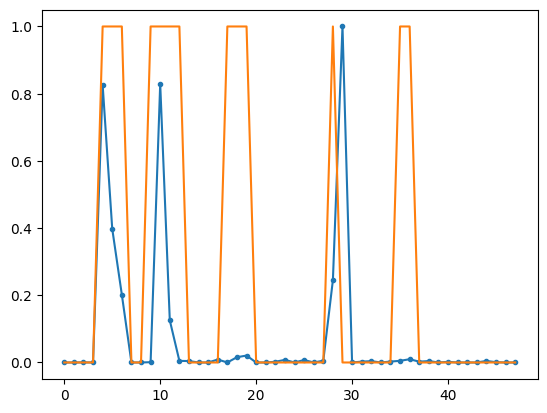

In [19]:
plt.plot(earthquake_scores/np.max(earthquake_scores), '.-', )
plt.plot(Y_test)

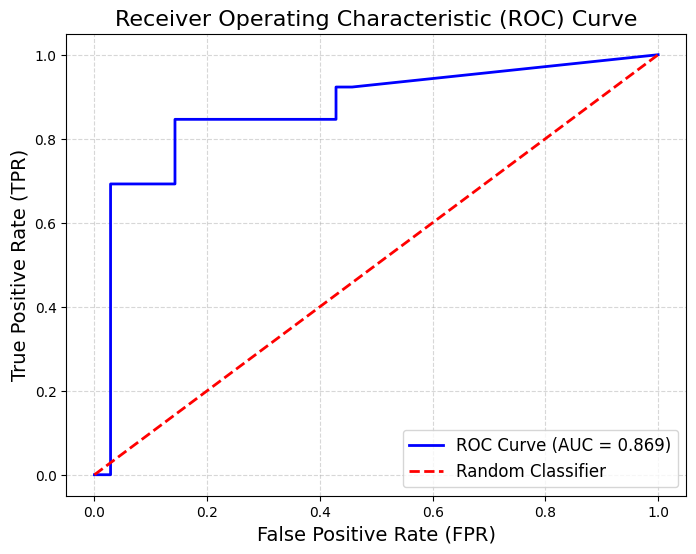

In [20]:
# ============================
# 7. Plot ROC curve.
# ============================
fpr, tpr, __ = roc_curve(Y_test, earthquake_scores)
auc_score = roc_auc_score(y_true=Y_test, y_score=earthquake_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Save Plots with Model And Test Data Names

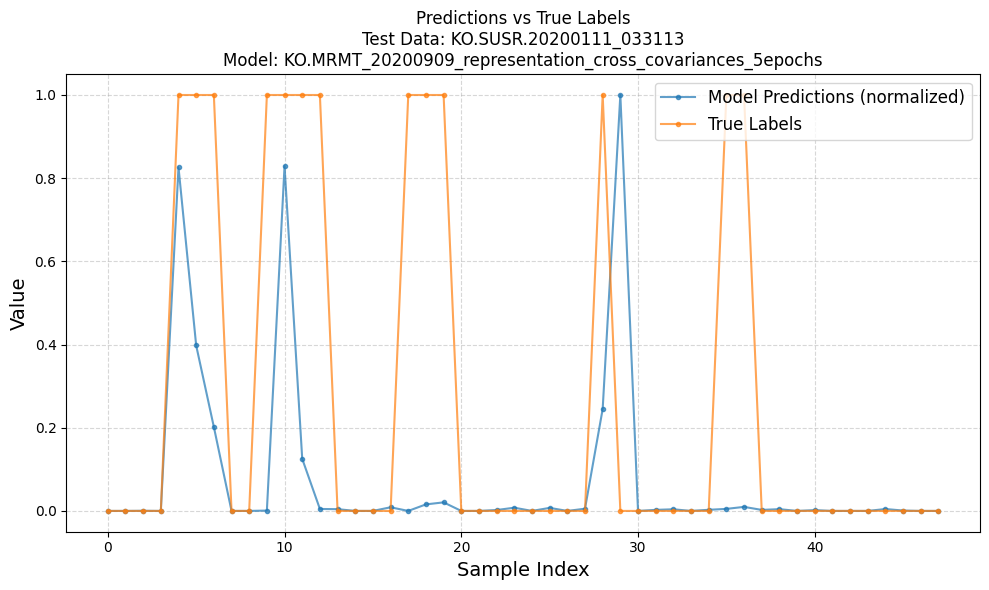

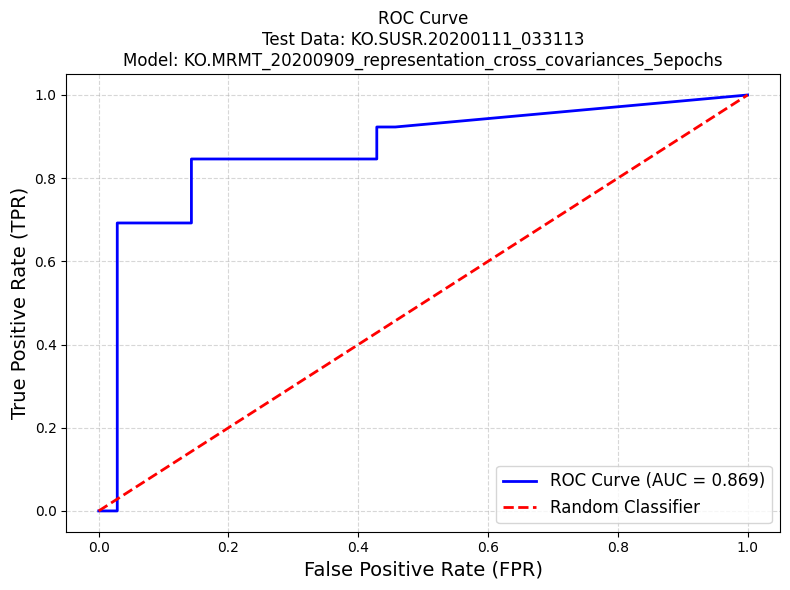

Plots saved for KO.SUSR.20200111_033113 with KO.MRMT_20200909_representation_cross_covariances_5epochs


In [21]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Extract names for titles
test_data_name = os.path.basename(TEST_DATA_PATH).replace('.npy', '')
model_name = os.path.basename(MODEL_PATH).replace('.h5', '')

# Create plots directory
os.makedirs('./plots', exist_ok=True)

# Plot 1: Predictions vs True Labels
plt.figure(figsize=(10, 6))
plt.plot(earthquake_scores/np.max(earthquake_scores), '.-', label='Model Predictions (normalized)', alpha=0.7)
plt.plot(Y_test, '.-', label='True Labels', alpha=0.7)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title(f'Predictions vs True Labels\nTest Data: {test_data_name}\nModel: {model_name}', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'./plots/{test_data_name}_{model_name}_predictions_vs_labels.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(Y_test, earthquake_scores)
auc_score = roc_auc_score(y_true=Y_test, y_score=earthquake_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve\nTest Data: {test_data_name}\nModel: {model_name}', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'./plots/{test_data_name}_{model_name}_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plots saved for {test_data_name} with {model_name}")

# OLD RESULTS

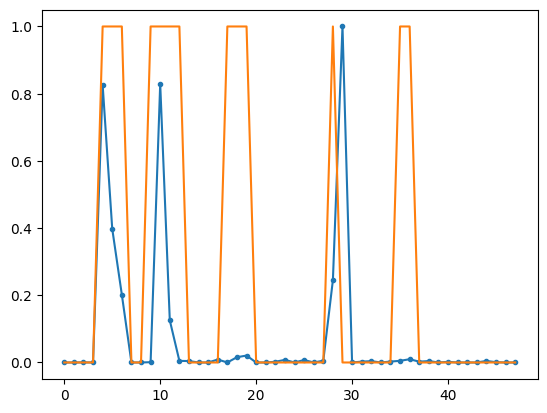

In [22]:
plt.plot(earthquake_scores/np.max(earthquake_scores), '.-', )
plt.plot(Y_test)

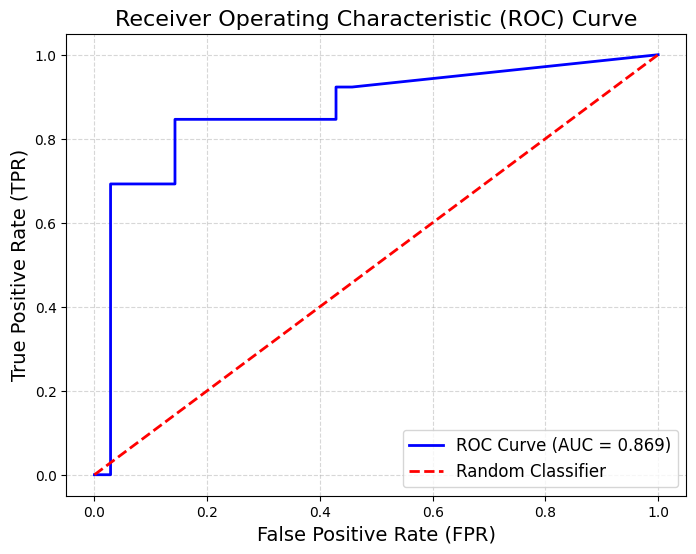

In [23]:
# ============================
# 7. Plot ROC curve.
# ============================
fpr, tpr, __ = roc_curve(Y_test, earthquake_scores)
auc_score = roc_auc_score(y_true=Y_test, y_score=earthquake_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [24]:
auc_score

0.8692307692307693

# Screenshots

![Screenshot From 2025-04-22 14-49-07.png](<attachment:Screenshot From 2025-04-22 14-49-07.png>) ![Screenshot From 2025-04-22 14-14-12.png](<attachment:Screenshot From 2025-04-22 14-14-12.png>) ![Screenshot From 2025-04-22 14-07-45.png](<attachment:Screenshot From 2025-04-22 14-07-45.png>) ![Screenshot From 2025-04-22 13-48-29.png](<attachment:Screenshot From 2025-04-22 13-48-29.png>) ![Screenshot From 2025-04-22 13-29-04.png](<attachment:Screenshot From 2025-04-22 13-29-04.png>)
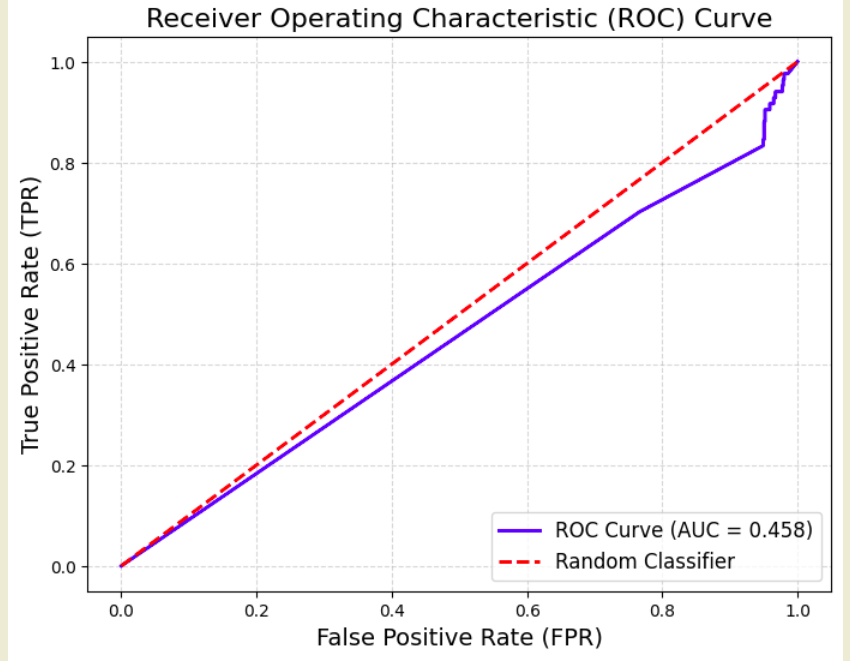
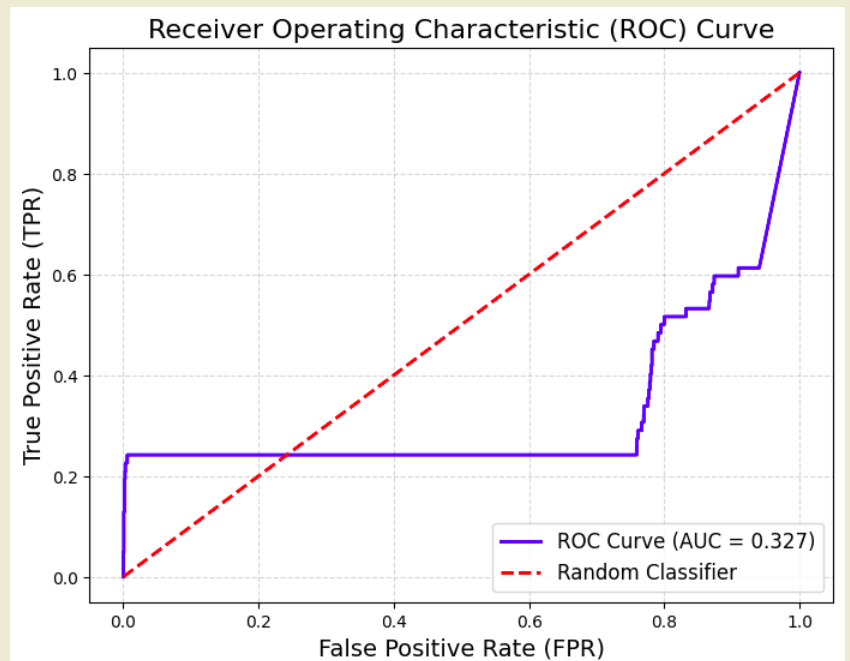
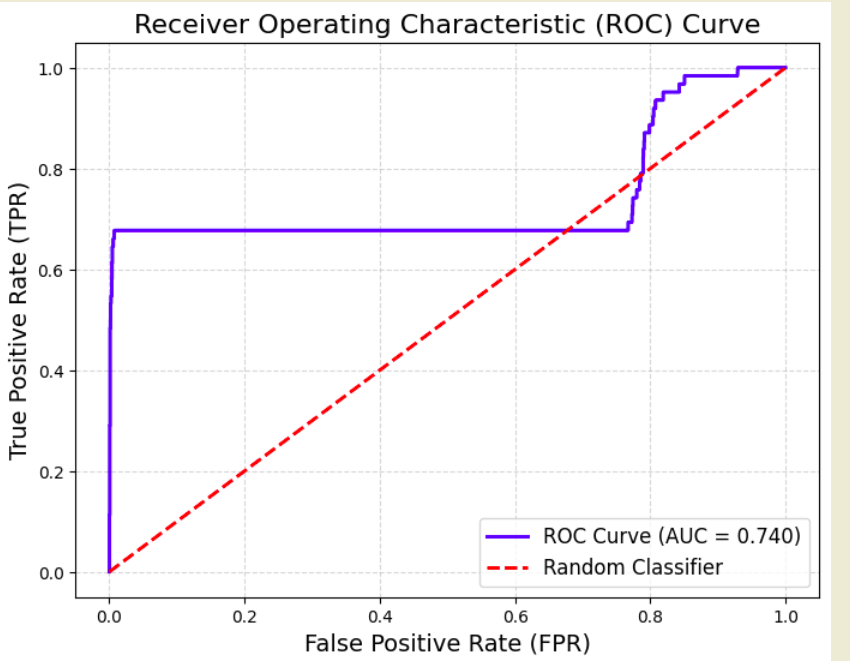
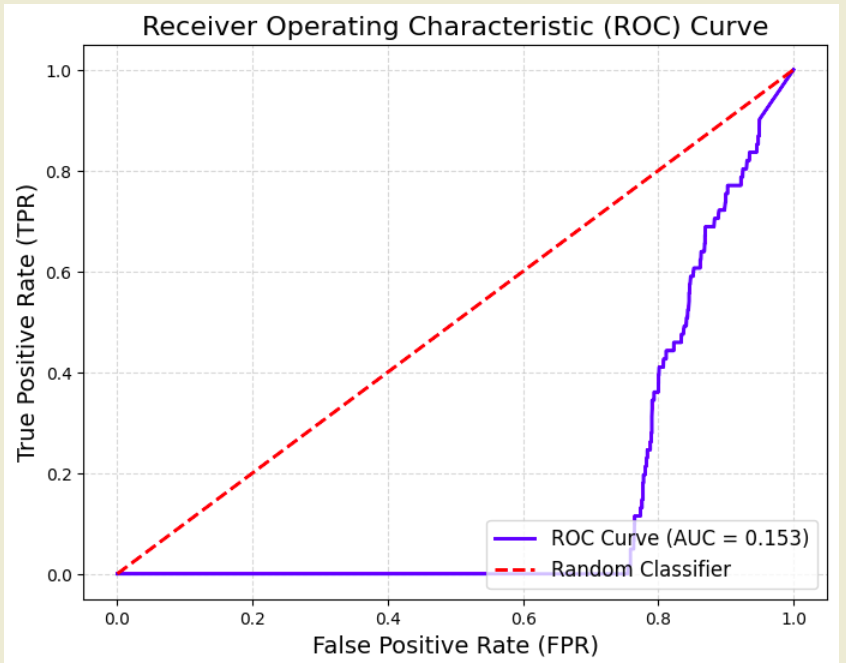
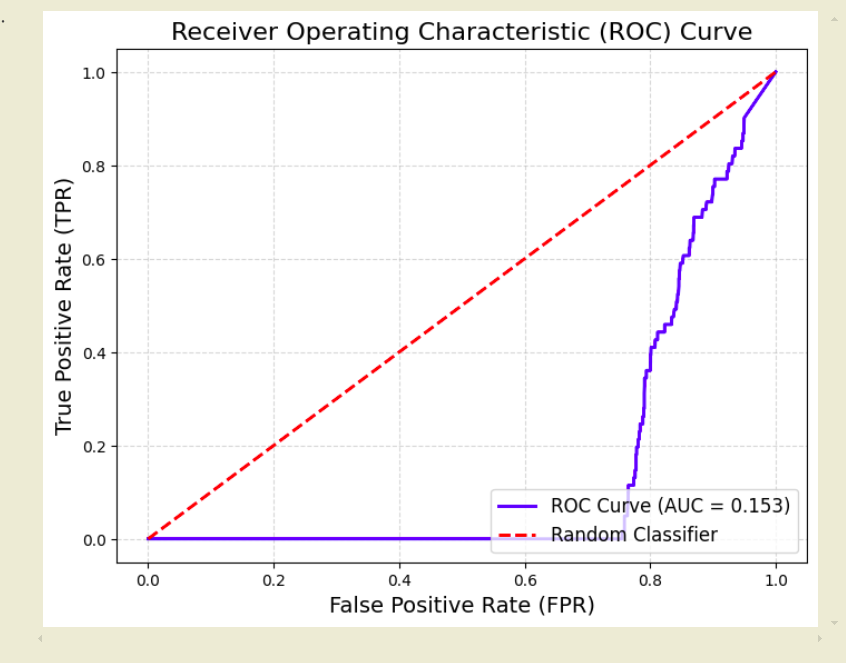